In [2]:
import torch
import torchvision

import torch.utils.data
from torch import nn
import torch.nn.functional as F
from torch import optim

from torchvision import datasets, transforms
from torchvision.utils import save_image

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torchvision.__version__

'0.14.0+cu116'

In [3]:
from torchvision.datasets import MNIST, CelebA

LR_transforms = transforms.Compose([transforms.Resize(14), transforms.ToTensor()])
training_data_lr = MNIST(root='./data', transform=LR_transforms, train=True, download=True)




In [8]:
# Root directory for the dataset
data_root = 'data/celeba'
# Spatial size of training images, images are resized to this size.
image_size = 64

celeba_data = datasets.CelebA(data_root,
                              download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                       std=[0.5, 0.5, 0.5])
                              ]))

Files already downloaded and verified


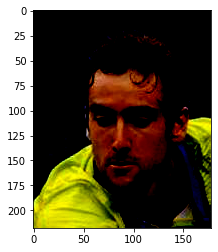

In [5]:
plt.imshow(celeba_data[100000][0].permute(1,2,0))

In [4]:
import typing
from torch import nn
from abc import abstractmethod
import torch


class BaseEncoder(nn.Module):
    def __init__(self) -> None:
        super(BaseEncoder, self).__init__()

    def forward(self, x: torch.tensor) -> torch.tensor:
        raise NotImplementedError

    def reparameterize(self, mu: torch.Tensor, logsigma: torch.Tensor) -> torch.Tensor:
        """
        Reparameterization trick to sample from N(mu, var): See Appendix
        The Encoder returns mean and log(variance). We then sample from Standard Normal Distribution, multiply and add to retrieve
        exp(0.5*log_sigma)*N(0,1) + mu          ~ N(mu, sigma)
        which then behaves like ~ N(mu, sigma) and thus we have sampled from latent space.
        :param mu: (torch.Tensor) Mean of the latent Gaussian [B x D]
        :param logsigma: (torch.Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (torch.Tensor) [B x D] ~ N(mu, sigma) for each element in batch
        """
        std = torch.exp(torch.mul(0.5, logsigma))
        # retrieve eps ~ N(0, sigma)
        eps = torch.randn_like(std)
        return eps * std + mu


class BaseDecoder(nn.Module):
    def __init__(self) -> None:
        super(BaseDecoder, self).__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError


class BaseVarAutoencoder(nn.Module):
    def __init__(self) -> None:
        super(BaseVarAutoencoder, self).__init__()

    def sample(self, batch_size: int, current_device: int, **kwargs) -> torch.Tensor:
        """
        this functions samples with given batch size from Standard Normal Distribution N(0,1) with latent dimension
        :param batch_size: how many samples to draw
        :param current_device: devide
        :param kwargs:
        :return:
        """
        standard_normal_samples = torch.randn(batch_size, self.latent_dimension)
        decoded = self.decoder(standard_normal_samples.to(current_device))
        return decoded

    def generate(self, x: torch.Tensor, **kwargs) -> torch.Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: torch.Tensor):
        pass

    @abstractmethod
    def loss(self, *inputs: typing.Any, **kwargs) -> dict:
        pass


class BaseConvBlock(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size,
                 stride,
                 padding: int,
                 max_pool: bool,
                 **kwargs):

        super(BaseConvBlock, self).__init__()
        self.conv_layer = nn.Conv2d(in_channels=in_channels,
                                    out_channels=out_channels,
                                    kernel_size=kernel_size,
                                    stride=stride,
                                    padding=padding)

        if max_pool:
            self.max_pooling = nn.MaxPool2d(kernel_size=kwargs["kernel_max_pool"], stride=kwargs["stride_max_pool"])
        else:
            # if we dont want to use maxpool, set kernel and stride to 1
            self.max_pooling = nn.MaxPool2d(kernel_size=1, stride=1)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor):
        out = self.conv_layer(x)
        out = self.max_pooling(out)
        out = self.batch_norm(out)
        return self.relu(out)


class BaseTransposeConvBlock(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size,
                 stride,
                 padding: int,
                 upsample: bool,
                 **kwargs):

        super(BaseTransposeConvBlock, self).__init__()
        self.transpose_conv_layer = nn.ConvTranspose2d(in_channels=in_channels,
                                                       out_channels=out_channels,
                                                       kernel_size=kernel_size,
                                                       stride=stride,
                                                       padding=padding,
                                                       output_padding=1)

        if upsample:
            self.upsample = nn.Upsample(scale_factor=kwargs["scale_factor"])
        else:
            # if we dont want to use upsample, set kernel and stride to 1
            self.upsample = nn.Upsample(scale_factor=1)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor):
        out = self.transpose_conv_layer(x)
        out = self.upsample(out)
        out = self.batch_norm(out)
        return self.relu(out)



In [45]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 800 kB 5.1 MB/s 
     |████████████████████████████████| 125 kB 62.2 MB/s 
     |████████████████████████████████| 512 kB 49.7 MB/s 


In [9]:
from torch.utils.data import DataLoader, Dataset

train_loader = DataLoader(celeba_data, batch_size=64)

In [13]:
next(iter(train_loader))[0].shape

torch.Size([64, 3, 218, 178])

In [25]:
len(celeba_data)

162770

In [46]:
from pytorch_lightning import LightningDataModule

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True


  
class VAEDataset(LightningDataModule):
    """
    PyTorch Lightning data module 

    Args:
        data_dir: root directory of your dataset.
        train_batch_size: the batch size to use during training.
        val_batch_size: the batch size to use during validation.
        patch_size: the size of the crop to take from the original images.
        num_workers: the number of parallel workers to create to load data
            items (see PyTorch's Dataloader documentation for more details).
        pin_memory: whether prepared items should be loaded into pinned memory
            or not. This can improve performance on GPUs.
    """

    def __init__(
        self,
        data_path: str,
        train_batch_size: int = 8,
        val_batch_size: int = 8,
        patch_size: Union[int, Sequence[int]] = (256, 256),
        num_workers: int = 0,
        pin_memory: bool = False,
        **kwargs,
    ):
        super().__init__()

        self.data_dir = data_path
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size
        self.patch_size = patch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory

    def setup(self, stage: Optional[str] = None) -> None:
#       =========================  OxfordPets Dataset  =========================
            
#         train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
#                                               transforms.CenterCrop(self.patch_size),
# #                                               transforms.Resize(self.patch_size),
#                                               transforms.ToTensor(),
#                                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        
#         val_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
#                                             transforms.CenterCrop(self.patch_size),
# #                                             transforms.Resize(self.patch_size),
#                                             transforms.ToTensor(),
#                                               transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

#         self.train_dataset = OxfordPets(
#             self.data_dir,
#             split='train',
#             transform=train_transforms,
#         )
        
#         self.val_dataset = OxfordPets(
#             self.data_dir,
#             split='val',
#             transform=val_transforms,
#         )
        
#       =========================  CelebA Dataset  =========================
    
        train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                              transforms.CenterCrop(148),
                                              transforms.Resize(self.patch_size),
                                              transforms.ToTensor(),])
        
        val_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                            transforms.CenterCrop(148),
                                            transforms.Resize(self.patch_size),
                                            transforms.ToTensor(),])
        ################## comment here
        self.train_dataset = MNIST(self.data_dir, train=True, transform=transforms.ToTensor())
        self.val_dataset = MNIST(self.data_dir, train=False, transform=transforms.ToTensor())

        self.train_dataset = MyCelebA(
            self.data_dir,
            split='train',
            transform=train_transforms,
            download=False,
        )
        
        # Replace CelebA with your dataset
        self.val_dataset = MyCelebA(
            self.data_dir,
            split='test',
            transform=val_transforms,
            download=False,
        )
        ########################
#       ===============================================================
        
    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            self.train_dataset,
            batch_size=self.train_batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=self.pin_memory,
        )

    def val_dataloader(self) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(
            self.val_dataset,
            batch_size=self.val_batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=self.pin_memory,
        )
    
    def test_dataloader(self) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(
            self.val_dataset,
            batch_size=144,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=self.pin_memory,
        )
     

NameError: ignored

In [5]:
import torch.nn.functional

class VarBayesianEncoder(BaseEncoder):
    def __init__(self,
                 in_channels: int,
                 hidden_dimensions,
                 latent_dimension: int,
                 kernel_size,
                 stride,
                 padding: int,
                 max_pool,
                 linear_layer_dimension: int):
        """
        Variational Bayesian Encoder
        :param in_channels: Define in Channels of Input image (e.g. for [1,28,28] --> 1)
        :param hidden_dimensions: define hidden dimensions for Convolutional Blocks: list of ints [32,64,128..]
        :param latent_dimension: The dimension of the latent space of which we will sample
        :param kernel_size: Kernel size of Conv Layers (e.g. (2,2) or (3,3)
        :param stride: Stride for Conv Layers (tuple of ints)
        :param padding: Padding for both [H,W]
        :param max_pool: list of boolean (needs to have same length as @hidden_dimensions). Defines wether to use Max Pool in Conv Block
        :param linear_layer_dimension: The input dimension for last linear layer (e.g. the output dimension of (H or W) of last Conv Block)
        """

        super(VarBayesianEncoder, self).__init__()
        self.in_channels = in_channels
        self.latent_dimension = latent_dimension

        conv_blocks_encoder = []
        for idx, hidden_dim in enumerate(hidden_dimensions):
            # Build Encoder
            conv_blocks_encoder.append(BaseConvBlock(in_channels=in_channels,
                                                     out_channels=hidden_dim,
                                                     kernel_size=kernel_size,
                                                     stride=stride,
                                                     padding=padding,
                                                     max_pool=max_pool[idx]))
            in_channels = hidden_dim

        self.encoder = nn.Sequential(*conv_blocks_encoder)
        # now add two dense layer to get mu and sigma from the latent space
        self.linear1 = nn.Linear(hidden_dimensions[-1] * linear_layer_dimension**2, latent_dimension)
        self.linear2 = nn.Linear(hidden_dimensions[-1] * linear_layer_dimension**2, latent_dimension)

    def forward(self, x: torch.Tensor):
        """
        Forward Method for input batch-image
        :param x: batch
        :return: mu, log(sigma) and sample from N(mu, sigma)
        """
        out = self.encoder(x)
        # get out tensor into [B, x] shape for linear Layers
        out = torch.flatten(out, start_dim=1)
        mu = self.linear1(out)
        logsigma = self.linear2(out)
        return [self.reparameterize(mu, logsigma), mu, logsigma]

    def check_forward_shape(self, x: torch.Tensor) -> torch.Tensor:
        """
        With this function you can check the dimensions/ shape of yout input tensor after the last convolutional block
        in order to define the input dimensions of the linear layers. For that first create an instance of class with
        dummy values.
        :param x: torch tensor of shape [B, C, H, W]
        :return: Tensor after conv layers (get shape by .size() or .shape
        """
        return self.encoder(x)



class VarBayesianDecoder(BaseDecoder):
    def __init__(self,
                 in_channels: int,
                 hidden_dimensions,
                 latent_dimension: int,
                 kernel_size,
                 stride,
                 padding: int,
                 upsample,
                 linear_layer_dimension: int):
        """
        Variational Bayesian Decoder
        :param in_channels: Define in Channels of initial Input image (e.g. for [1,28,28] --> 1)
        :param hidden_dimensions: define hidden dimensions for Transp-Convolutional Blocks: list of ints [32,64,128..]
        :param latent_dimension: The dimension of the latent space of which we will sample
        :param kernel_size: Kernel size of Transp-Conv Layers (e.g. (2,2) or (3,3)
        :param stride: Stride for Transp-Conv Layers (tuple of ints)
        :param padding: Padding for both [H,W]
        :param upsample: list of boolean (needs to have same length as @hidden_dimensions). Defines wether to use Upsample in Transp-Conv Block
        :param linear_layer_dimension: The input dimension for last linear layer (e.g. the output dimension of (H or W) of last Conv Block)
        """
        super(VarBayesianDecoder, self).__init__()
        self.in_channels = in_channels
        self.latent_dimension = latent_dimension

        # we use same hidden dimension as encoder ([32,64,128...]) but as we now want to transpose/ decode, we reverse order
        hidden_dimensions.reverse()

        # first add linear layer to reshape sampled vector from latent space
        self.linear_dim = linear_layer_dimension
        self.hidden_dim_first = hidden_dimensions[0]
        self.linear = nn.Linear(latent_dimension, self.linear_dim**2 * self.hidden_dim_first)

        conv_blocks_decoder = []
        for idx, hidden_dim in enumerate(hidden_dimensions):
            if idx != len(hidden_dimensions)-1:
                in_channels = hidden_dim
                out_channels = hidden_dimensions[idx + 1]
            else:
                in_channels = hidden_dim
                out_channels = self.in_channels
            # Build Decoder
            conv_blocks_decoder.append(BaseTransposeConvBlock(in_channels=in_channels,#hidden_dim,
                                                              out_channels=out_channels,#hidden_dimensions[idx + 1],
                                                              kernel_size=kernel_size,
                                                              stride=stride,
                                                              padding=padding,
                                                              upsample=upsample[idx]))
        self.decoder = nn.Sequential(*conv_blocks_decoder)
        # add one last layer as heigt, weight of image is bigger then initally
        self.final_layer = nn.Conv2d(in_channels=self.in_channels,
                                     out_channels=self.in_channels,
                                     kernel_size=(6, 6),
                                     stride=(1, 1),
                                     padding=0)
        #self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor):
        """
        Forward method of Decoder
        :param x: Batch of samples from Latent Space
        :return: Batch of reconstructed Images
        """
        out = self.linear(x)
        # now reshape tensor of shape [B, hidden_dimensions[0] * linear_layer_dimension**2]
        out = out.view(-1, self.hidden_dim_first, self.linear_dim, self.linear_dim)
        out = self.decoder(out)
        out = self.final_layer(out)
        return self.sigmoid(out)


class BetaVAE(BaseVarAutoencoder):
    def __init__(self,
                 in_channels: int,
                 hidden_dimensions,
                 latent_dimension: int,
                 kernel_size,
                 stride,
                 padding: int,
                 max_pool,
                 linear_layer_dimension: int):
        super(BetaVAE, self).__init__()

        self.latent_dimension = latent_dimension
        self.encoder = VarBayesianEncoder(in_channels=in_channels,
                                          hidden_dimensions=hidden_dimensions,
                                          latent_dimension=latent_dimension,
                                          kernel_size=kernel_size,
                                          stride=stride,
                                          padding=padding,
                                          max_pool=max_pool,
                                          linear_layer_dimension=linear_layer_dimension)

        self.decoder = VarBayesianDecoder(in_channels=in_channels,
                                          hidden_dimensions=hidden_dimensions,
                                          latent_dimension=latent_dimension,
                                          kernel_size=kernel_size,
                                          stride=stride,
                                          padding=padding,
                                          upsample=max_pool,
                                          linear_layer_dimension=linear_layer_dimension)

    def forward(self, inputs: torch.Tensor):
        """
        Forward Method for Variational Autoencoder
        :param inputs: Takes a batch of images of inital size as an input [B,C,H,W]
        :return: [reconstruction, inputs, sample from latent space, mu, log_sigma]
        """
        encode = self.encoder(inputs)
        decode = self.decoder(encode[0])
        return [decode, inputs] + encode

    def loss(self, inputs: list, **kwargs) -> dict:
        """
        The loss function for Variational Bayesian AE
        :param inputs: [reconstruction, orig_input, latent_sample, mu, log_sigma], which is exactly the output of forward pass
        :param kwargs: We need following two parameters: "KL_divergence_weight" and which MSE Loss to use: "mse_reduction"
        :return:
        """
        reconstruction, orig_input, latent_sample, mu, log_sigma = inputs[0], inputs[1], inputs[2], inputs[3], inputs[4]

        reconstruction_loss = nn.functional.binary_cross_entropy(reconstruction, orig_input, reduction=kwargs["mse_reduction"])

        reconstruction_loss = reconstruction_loss / kwargs["batch_size"]

        # for derivation of KL Term of two Std. Normals, see Appendix TODO!
        # KL_divergence_loss = torch.mean(-0.5 * torch.sum(1 + log_sigma - mu ** 2 - log_sigma.exp(), dim=1), dim=0)
        KL_divergence_loss = -0.5 * torch.mean(1 + log_sigma - mu ** 2 - log_sigma.exp(), dim=0)
        KL_divergence_loss = torch.sum(KL_divergence_loss)

        # Add a weight to KL divergence term as the loss otherwise is too much dominated by this term!
        # For Validation we set this to 1
        KL_divergence_weight = kwargs["KL_divergence_weight"]
        kld_factor = self.linear_scale_kld_factor(kwargs["current_train_step"], 
                                                  kwargs["first_k_train_steps"], 
                                                  0, 
                                                  1) if kwargs["scale_kld"] else 1

        total_loss = reconstruction_loss + kld_factor * (KL_divergence_weight * KL_divergence_loss)

        return {"total_loss": total_loss,
                "kl_divergence_loss": KL_divergence_loss,
                "reconstruction_loss": reconstruction_loss}

    def linear_scale_kld_factor(self, current_training_step: int, first_k_train_steps: int, min_value=0, max_value=1):
      if first_k_train_steps==0:
        return max_value
      delta = max_value - min_value
      scale_factor = min(min_value + delta * current_training_step/ first_k_train_steps, max_value)
      return

      

In [21]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 800 kB 5.1 MB/s 
     |████████████████████████████████| 512 kB 4.4 MB/s 
     |████████████████████████████████| 125 kB 45.5 MB/s 


In [6]:
import torch
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
import torchvision.utils as vutils


def interpolate_2_images(model,
                         test_data_loader,
                         label_1: int,
                         label_2: int,
                         device,
                         path,
                         n=12):
    """
    This function interpolates between two images: Both images are encoded, then the latent representations are interpolated with n steps
    :param model: VAE model (nn.Module subclassed)
    :param test_data_loader: Test Data Loader
    :param label_1: labels, e.g. 1 or 2
    :param label_2: labels
    :param device: device (gpu/ cpu)
    :param path: path to save image
    :param n: how many images we interpolate between those two
    :return:
    """
    x, y = next(iter(test_data_loader))  # hack to grab a batch
    x_1 = x[y == label_1][1].unsqueeze(dim=0)
    x_2 = x[y == label_2][1].unsqueeze(dim=0)
    z_1 = model.encoder(x_1.to(device))[0]
    z_2 = model.encoder(x_2.to(device))[0]
    z = torch.stack([z_1 + (z_2 - z_1) * t for t in np.linspace(0, 1, n)])
    interpolate_list = model.decoder(z)

    vutils.save_image(interpolate_list.cpu().data,
                      path,
                      normalize=True,
                      nrow=n)

def plot_from_distribution(model,
                           test_data_loader,
                           nrow_ncols: (int, int),
                           label: int,
                           noise: float = 0.0):
    x, y = next(iter(test_data_loader))
    x = x[y == label][1]

    fig = plt.figure(figsize=(4., 4.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=nrow_ncols)

    x_1_latent = model.model.encoder(x.unsqueeze(dim=1))
    for ax in grid:
        standard_gauss = torch.randn_like(x_1_latent[1])
        sample_latent = x_1_latent[1] + standard_gauss * torch.exp(0.5 * x_1_latent[2])

        sample_latent += noise * torch.randn_like(x_1_latent[1])

        sample_construct = model.model.decoder(sample_latent)[0]

        #orig_z = model.model.decoder(x_1_latent[0])[0]
        # ax.imshow(orig_z.permute(1, 2, 0).detach().numpy())
        ax.imshow(sample_construct.permute(1, 2, 0).detach().numpy())
    plt.show()


def plot_2d_latent_space(autoencoder, r0=(-1, 1), r1=(-1, 1), n=50, input_dimension=[1, 28, 28]):
    """
    :param autoencoder:
    :param r0: borders for drawing from latent space
    :param r1: borders for drawing from latent space
    :param n: nxn grid
    :param input_dimension: input dimension of one image
    :return:
    """
    latent_space = torch.empty(n, n, input_dimension[0], input_dimension[1], input_dimension[2])
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]])#.to(device)
            latent_space[i, j] = autoencoder.decoder(z)
    latent_space = latent_space.cpu().data.view(-1, input_dimension[0], input_dimension[1], input_dimension[2])
    vutils.save_image(latent_space,
                      "./plots/2d_latent_space.png",
                      normalize=True,
                      nrow=n)
    return latent_space

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms, utils
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import yaml
from pytorch_lightning.loggers import TensorBoardLogger


class VAETrainer(pl.LightningModule):
    def __init__(self, model: BaseVarAutoencoder, params):
        super(VAETrainer, self).__init__()
        self.model = model
        self.params = params
        self.save_hyperparameters()
        self.current_device = params["devices"]
        self.current_training_step = 0
        
    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.params["learning_rate"])
        return optimizer

    def training_step(self, train_batch, batch_idx):
        self.current_training_step += 1
        x, y = train_batch
        self.current_device = x.device
        output = self.forward(x)
        loss = self.model.loss(output,
                               current_train_step=self.current_training_step,
                               **self.params)

        self.log_dict({f"train_{loss_key}": loss_val.item() for loss_key, loss_val in loss.items()})

        return loss["total_loss"]

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        self.current_device = x.device
        output = self.forward(x)
        loss = self.model.loss(output,
                               mse_reduction=self.params["mse_reduction"],
                               KL_divergence_weight=1) # for validation step set KLD weight always to 1

        self.log_dict({f"valid_{loss_key}": loss_val.item() for loss_key, loss_val in loss.items()})

        # Log reconstructed validation images!
        tensorboard = self.logger.experiment
        img_grid = utils.make_grid(output[0])
        tensorboard.add_image(f'Reconstructed Images {self.current_epoch}', img_grid)
        # It seems like validation batches are shuffled
        img_grid = utils.make_grid(output[1])
        tensorboard.add_image(f'Original Images {self.current_epoch}', img_grid)

        return loss["total_loss"]

    def on_validation_epoch_end(self) -> None:
        """
        At the end of epoch we want to Sample from Latent Space and log these
        :return:
        """
        sampled = self.model.sample(144, self.current_device)
        img_grid = utils.make_grid(sampled)
        tensorboard = self.logger.experiment
        tensorboard.add_image(f'Sampled Images {self.current_epoch}', img_grid)

    def on_train_end(self) -> None:
        #interpolate_2_images(self.model,
        #                     test_loader,
        #                     label_1=1,
        #                     label_2=3,
        #                     n=12,
        #                     device=self.current_device,
        #                     path=self.params["plot_2_interpolate_dir"])
        sampled = self.model.sample(144, self.current_device)
        img_grid = utils.make_grid(sampled, nrow=12)
        vutils.save_image(img_grid.cpu().data,
                          self.params["plot_sample"],
                          normalize=True,
                          nrow=12)


if __name__ == "__main__":
    with open("configs/beta_vae.yaml", encoding='utf8') as conf:
        config = yaml.load(conf, Loader=yaml.FullLoader)
        conf.close()
    # use MNIST Dataset and load training and test data
    #training_data = MNIST(root='./data', transform=transforms.ToTensor(), train=True, download=True)

    #test_loader = torch.utils.data.DataLoader(
    #    MNIST(root='./data', transform=transforms.ToTensor(), train=False, download=True),
    #    batch_size=128,
    #    shuffle=True)

    train_size = int(config["train_valid_split"] * len(celeba_data))
    val_size = len(celeba_data) - train_size
    train_set, val_set = torch.utils.data.random_split(celeba_data, [train_size, val_size])
    
    # Load data into torch Dataloader
    train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=64, shuffle=True)

    #train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
    #val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=True)

    #vae = SigmaVAE(in_channels=config["input_image_size"][0],
    #               hidden_dimensions=config["hidden_dimensions"],
    #               latent_dimension=config["latent_dimension"],
    #               kernel_size=config["kernel_size"],
    #               stride=config["stride"],
    #               padding=config["padding"],
    #               max_pool=config["max_pool"],
    #               linear_layer_dimension=config["linear_layer_dimension"])

    vae = BetaVAE(in_channels=config["input_image_size"][0],
                        hidden_dimensions=config["hidden_dimensions"],
                        latent_dimension= config["latent_dimension"],
                        kernel_size=config["kernel_size"],
                        stride=config["stride"],
                        padding=config["padding"],
                        max_pool=config["max_pool"],
                        linear_layer_dimension=config["linear_layer_dimension"])

    #vae = LinearVAE(input_dimension=config["input_image_size"],
    #                hidden_dimensions=config["hidden_dimensions"],
    #                latent_dim=config["latent_dim"])

    tb_logger = TensorBoardLogger(save_dir=config['logging_dir'],
                                  name=config['logging_name'])

    # config contains further hyperparameters (LR/ KLD Weight/ MSE Reduction)
    model = VAETrainer(model=vae, params=config)
    trainer = pl.Trainer(callbacks=[EarlyStopping(monitor="valid_total_loss", mode="min")],
                         logger=tb_logger,
                         max_epochs=config["epochs"])
    trainer.fit(model, train_loader, val_loader)





In [ ]:
from torch.utils.data import Dataset
import pandas as pd
## https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/mechanics/custom-data-loader-celeba.ipynb
import subprocess
import os
import abc
import hashlib
import zipfile
import glob
import logging
import tarfile
from skimage.io import imread
from PIL import Image
from tqdm import tqdm
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets





class DisentangledDataset(Dataset, abc.ABC):
    """Base Class for disentangled VAE datasets.
    Parameters
    ----------
    root : string
        Root directory of dataset.
    transforms_list : list
        List of `torch.vision.transforms` to apply to the data when loading it.
    """

    def __init__(self, root, transforms_list=[], logger=logging.getLogger(__name__)):
        self.root = root
        self.train_data = os.path.join(root, type(self).files["train"])
        self.transforms = transforms.Compose(transforms_list)
        self.logger = logger

        if not os.path.isdir(root):
            self.logger.info("Downloading {} ...".format(str(type(self))))
            self.download()
            self.logger.info("Finished Downloading.")

    def __len__(self):
        return len(self.imgs)

    @abc.abstractmethod
    def __getitem__(self, idx):
        """Get the image of `idx`.
        Return
        ------
        sample : torch.Tensor
            Tensor in [0.,1.] of shape `img_size`.
        """
        pass

    @abc.abstractmethod
    def download(self):
        """Download the dataset. """
        pass


class CelebA(DisentangledDataset):
    """CelebA Dataset from [1].
    CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset
    with more than 200K celebrity images, each with 40 attribute annotations.
    The images in this dataset cover large pose variations and background clutter.
    CelebA has large diversities, large quantities, and rich annotations, including
    10,177 number of identities, and 202,599 number of face images.
    Notes
    -----
    - Link : http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
    Parameters
    ----------
    root : string
        Root directory of dataset.
    References
    ----------
    [1] Liu, Z., Luo, P., Wang, X., & Tang, X. (2015). Deep learning face
        attributes in the wild. In Proceedings of the IEEE international conference
        on computer vision (pp. 3730-3738).
    """
    urls = {"train": "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip"}
    files = {"train": "img_align_celeba"}
    img_size = (3, 64, 64)
    background_color = COLOUR_WHITE

    def __init__(self, root=os.path.join(DIR, '../data/celeba'), **kwargs):
        super().__init__(root, [transforms.ToTensor()], **kwargs)

        self.imgs = glob.glob(self.train_data + '/*')

    def download(self):
        """Download the dataset."""
        save_path = os.path.join(self.root, 'celeba.zip')
        os.makedirs(self.root)
        subprocess.check_call(["curl", "-L", type(self).urls["train"],
                               "--output", save_path])

        hash_code = '00d2c5bc6d35e252742224ab0c1e8fcb'
        assert hashlib.md5(open(save_path, 'rb').read()).hexdigest() == hash_code, \
            '{} file is corrupted.  Remove the file and try again.'.format(save_path)

        with zipfile.ZipFile(save_path) as zf:
            self.logger.info("Extracting CelebA ...")
            zf.extractall(self.root)

        os.remove(save_path)

        self.logger.info("Resizing CelebA ...")
        preprocess(self.train_data, size=type(self).img_size[1:])

    def __getitem__(self, idx):
        """Get the image of `idx`
        Return
        ------
        sample : torch.Tensor
            Tensor in [0.,1.] of shape `img_size`.
        placeholder :
            Placeholder value as their are no targets.
        """
        img_path = self.imgs[idx]
        # img values already between 0 and 255
        img = imread(img_path)

        # put each pixel in [0.,1.] and reshape to (C x H x W)
        img = self.transforms(img)

        # no label so return 0 (note that can't return None because)
        # dataloaders requires so
        return img, 0


# HELPERS
def preprocess(root, size=(64, 64), img_format='JPEG', center_crop=None):
    """Preprocess a folder of images.
    Parameters
    ----------
    root : string
        Root directory of all images.
    size : tuple of int
        Size (width, height) to rescale the images. If `None` don't rescale.
    img_format : string
        Format to save the image in. Possible formats:
        https://pillow.readthedocs.io/en/3.1.x/handbook/image-file-formats.html.
    center_crop : tuple of int
        Size (width, height) to center-crop the images. If `None` don't center-crop.
    """
    imgs = []
    for ext in [".png", ".jpg", ".jpeg"]:
        imgs += glob.glob(os.path.join(root, '*' + ext))

    for img_path in tqdm(imgs):
        img = Image.open(img_path)
        width, height = img.size

        if size is not None and width != size[1] or height != size[0]:
            img = img.resize(size, Image.ANTIALIAS)

        if center_crop is not None:
            new_width, new_height = center_crop
            left = (width - new_width) // 2
            top = (height - new_height) // 2
            right = (width + new_width) // 2
            bottom = (height + new_height) // 2

            img.crop((left, top, right, bottom))

        img.save(img_path, img_format)

In [33]:
"""
Module containing all vae losses.
"""
import abc
import math

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import optim

#from disvae.utils.math import (log_density_gaussian, log_importance_weight_matrix,
#                              matrix_log_density_gaussian)


LOSSES = ["VAE", "betaH", "betaB", "factor", "btcvae"]
RECON_DIST = ["bernoulli", "laplace", "gaussian"]

class BaseLoss(abc.ABC):
    """
    Base class for losses.
    Parameters
    ----------
    record_loss_every: int, optional
        Every how many steps to recorsd the loss.
    rec_dist: {"bernoulli", "gaussian", "laplace"}, optional
        Reconstruction distribution istribution of the likelihood on the each pixel.
        Implicitely defines the reconstruction loss. Bernoulli corresponds to a
        binary cross entropy (bse), Gaussian corresponds to MSE, Laplace
        corresponds to L1.
    steps_anneal: nool, optional
        Number of annealing steps where gradually adding the regularisation.
    """

    def __init__(self, record_loss_every=50, rec_dist="bernoulli", steps_anneal=0):
        self.n_train_steps = 0
        self.record_loss_every = record_loss_every
        self.rec_dist = rec_dist
        self.steps_anneal = steps_anneal

    @abc.abstractmethod
    def __call__(self, data, recon_data, latent_dist, is_train, storer, **kwargs):
        """
        Calculates loss for a batch of data.
        Parameters
        ----------
        data : torch.Tensor
            Input data (e.g. batch of images). Shape : (batch_size, n_chan,
            height, width).
        recon_data : torch.Tensor
            Reconstructed data. Shape : (batch_size, n_chan, height, width).
        latent_dist : tuple of torch.tensor
            sufficient statistics of the latent dimension. E.g. for gaussian
            (mean, log_var) each of shape : (batch_size, latent_dim).
        is_train : bool
            Whether currently in train mode.
        storer : dict
            Dictionary in which to store important variables for vizualisation.
        kwargs:
            Loss specific arguments
        """

    def _pre_call(self, is_train, storer):
        if is_train:
            self.n_train_steps += 1

        if not is_train or self.n_train_steps % self.record_loss_every == 1:
            storer = storer
        else:
            storer = None

        return storer



class BetaHLoss(BaseLoss):
    """
    Compute the Beta-VAE loss as in [1]
    Parameters
    ----------
    beta : float, optional
        Weight of the kl divergence.
    kwargs:
        Additional arguments for `BaseLoss`, e.g. rec_dist`.
    References
    ----------
        [1] Higgins, Irina, et al. "beta-vae: Learning basic visual concepts with
        a constrained variational framework." (2016).
    """

    def __init__(self, beta=4, **kwargs):
        super().__init__(**kwargs)
        self.beta = beta

    def __call__(self, data, recon_data, latent_dist, is_train, storer, **kwargs):
        storer = self._pre_call(is_train, storer)

        rec_loss = _reconstruction_loss(data, recon_data,
                                        storer=storer,
                                        distribution=self.rec_dist)
        kl_loss = _kl_normal_loss(*latent_dist, storer)
        anneal_reg = (linear_annealing(0, 1, self.n_train_steps, self.steps_anneal)
                      if is_train else 1)
        loss = rec_loss + anneal_reg * (self.beta * kl_loss)

        if storer is not None:
            storer['loss'].append(loss.item())

        return loss


def _reconstruction_loss(data, recon_data, distribution="bernoulli", storer=None):
  """
  Calculates the per image reconstruction loss for a batch of data. I.e. negative
  log likelihood.
  Parameters
  ----------
  data : torch.Tensor
      Input data (e.g. batch of images). Shape : (batch_size, n_chan,
      height, width).
  recon_data : torch.Tensor
      Reconstructed data. Shape : (batch_size, n_chan, height, width).
  distribution : {"bernoulli", "gaussian", "laplace"}
      Distribution of the likelihood on the each pixel. Implicitely defines the
      loss Bernoulli corresponds to a binary cross entropy (bse) loss and is the
      most commonly used. It has the issue that it doesn't penalize the same
      way (0.1,0.2) and (0.4,0.5), which might not be optimal. Gaussian
      distribution corresponds to MSE, and is sometimes used, but hard to train
      ecause it ends up focusing only a few pixels that are very wrong. Laplace
      distribution corresponds to L1 solves partially the issue of MSE.
  storer : dict
      Dictionary in which to store important variables for vizualisation.
  Returns
  -------
  loss : torch.Tensor
      Per image cross entropy (i.e. normalized per batch but not pixel and
      channel)
  """
  batch_size, n_chan, height, width = recon_data.size()
  is_colored = n_chan == 3

  if distribution == "bernoulli":
      loss = F.binary_cross_entropy(recon_data, data, reduction="sum")
  elif distribution == "gaussian":
      # loss in [0,255] space but normalized by 255 to not be too big
      loss = F.mse_loss(recon_data * 255, data * 255, reduction="sum") / 255
  elif distribution == "laplace":
      # loss in [0,255] space but normalized by 255 to not be too big but
      # multiply by 255 and divide 255, is the same as not doing anything for L1
      loss = F.l1_loss(recon_data, data, reduction="sum")
      loss = loss * 3  # emperical value to give similar values than bernoulli => use same hyperparam
      loss = loss * (loss != 0)  # masking to avoid nan
  else:
      assert distribution not in RECON_DIST
      raise ValueError("Unkown distribution: {}".format(distribution))

  loss = loss / batch_size

  if storer is not None:
      storer['recon_loss'].append(loss.item())

  return loss


def _kl_normal_loss(mean, logvar, storer=None):
  """
  Calculates the KL divergence between a normal distribution
  with diagonal covariance and a unit normal distribution.
  Parameters
  ----------
  mean : torch.Tensor
      Mean of the normal distribution. Shape (batch_size, latent_dim) where
      D is dimension of distribution.
  logvar : torch.Tensor
      Diagonal log variance of the normal distribution. Shape (batch_size,
      latent_dim)
  storer : dict
      Dictionary in which to store important variables for vizualisation.
  """
  latent_dim = mean.size(1)
  # batch mean of kl for each latent dimension
  latent_kl = 0.5 * (-1 - logvar + mean.pow(2) + logvar.exp()).mean(dim=0)
  total_kl = latent_kl.sum()

  if storer is not None:
      storer['kl_loss'].append(total_kl.item())
      for i in range(latent_dim):
          storer['kl_loss_' + str(i)].append(latent_kl[i].item())

  return total_kl 

def linear_annealing(init, fin, step, annealing_steps):
    """Linear annealing of a parameter."""
    if annealing_steps == 0:
        return fin
    assert fin > init
    delta = fin - init
    annealed = min(init + delta * step / annealing_steps, fin)
    return annealed

In [39]:
linear_annealing(0, 1, 10000000, 10000)


1

In [16]:
from torch.utils.data import dataloader
train_data = dataloader(celeba_data, batchsize=64)

TypeError: ignored

In [12]:
batch = next(iter(training_data_lr))

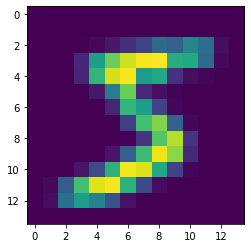

In [13]:
plt.imshow(batch[0].squeeze())